In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

import plotly.express as px

from urllib.request import urlopen
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_theme()

In [3]:
train_raw = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
train_raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
train_raw.dtypes

row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

In [5]:
print('Number of states:', train_raw['state'].nunique())
print('Number of counties:', train_raw['cfips'].nunique())

Number of states: 51
Number of counties: 3135


In [6]:
cfips_county_state = train_raw[['cfips', 'county', 'state']].drop_duplicates()

In [7]:
counties_mean = train_raw.groupby('cfips').mean().reset_index()
counties_mean = counties_mean.merge(cfips_county_state, on ='cfips', how='inner')
counties_mean.head()

,cfips,microbusiness_density,active,county,state
0,1001,3.164535,1331.717949,Autauga County,Alabama
1,1003,7.889811,13064.538462,Baldwin County,Alabama
2,1005,1.102521,222.102564,Barbour County,Alabama
3,1007,1.270834,226.769231,Bibb County,Alabama
4,1009,1.676951,742.230769,Blount County,Alabama


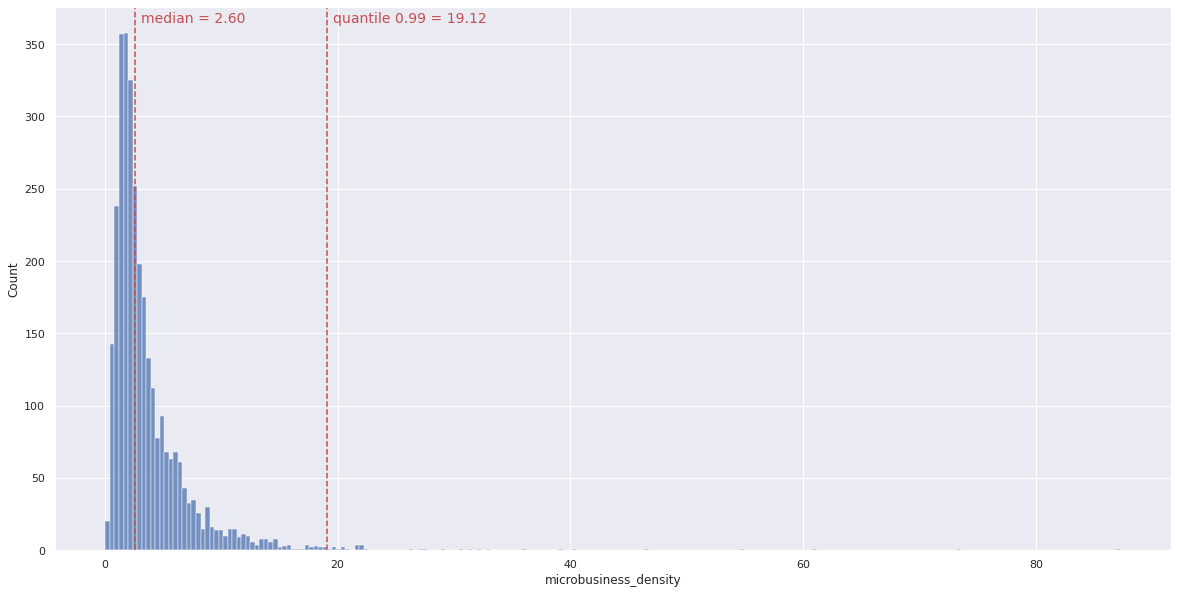

In [8]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.histplot(data=counties_mean, x='microbusiness_density', ax=ax)

raw_median = counties_mean['microbusiness_density'].median()
ax.axvline(raw_median, 0, c='r', ls='--')
ax.text(raw_median+0.5, 365, f"median = {raw_median:.2f}", size=14, horizontalalignment='left', c='r')

q99 = counties_mean['microbusiness_density'].quantile(0.99)
ax.axvline(q99, 0, c='r', ls='--')
ax.text(q99+0.5, 365, f"quantile 0.99 = {q99:.2f}", size=14, c='r')
plt.show()

In [9]:
tail = counties_mean[counties_mean['microbusiness_density']>q99]
print(f'Number of counties in the tail: {len(tail)}\n')
print(tail.sort_values(by='microbusiness_density', ascending=False)[:10])

Number of counties in the tail: 32

      cfips  microbusiness_density         active             county         state
1760  32510              87.196625   38078.384615        Carson City        Nevada
3128  56033              73.510410   17455.794872    Sheridan County       Wyoming
295    8105              60.942899    5305.948718  Rio Grande County      Colorado
2235  41061              54.522958   11141.538462       Union County        Oregon
559   16021              46.730638    4276.282051    Boundary County         Idaho
1752  32017              40.140351    1695.589744     Lincoln County        Nevada
837   19101              39.112656    5803.230769   Jefferson County          Iowa
2794  49043              35.871770   11004.333333      Summit County          Utah
1855  36061              32.892037  460102.051282    New York County      New York
2407  46099              32.261295   45412.897436   Minnehaha County  South Dakota


In [10]:
tail = counties_mean[counties_mean['microbusiness_density']>q99]
print(f'Number of counties in the tail: {len(tail)}\n')
print(tail.sort_values(by='microbusiness_density', ascending=False)[:10])

Number of counties in the tail: 32

      cfips  microbusiness_density         active             county         state
1760  32510              87.196625   38078.384615        Carson City        Nevada
3128  56033              73.510410   17455.794872    Sheridan County       Wyoming
295    8105              60.942899    5305.948718  Rio Grande County      Colorado
2235  41061              54.522958   11141.538462       Union County        Oregon
559   16021              46.730638    4276.282051    Boundary County         Idaho
1752  32017              40.140351    1695.589744     Lincoln County        Nevada
837   19101              39.112656    5803.230769   Jefferson County          Iowa
2794  49043              35.871770   11004.333333      Summit County          Utah
1855  36061              32.892037  460102.051282    New York County      New York
2407  46099              32.261295   45412.897436   Minnehaha County  South Dakota


In [11]:
def show_county(cfips, txt_off=5):
    county_data = train_raw[train_raw['cfips']==cfips]
    county_data['date'] = pd.to_datetime(county_data['first_day_of_month']).dt.to_period('M')
    county_data['date'] = county_data['date'].astype(str)
    
    
    fig, ax = plt.subplots(figsize=(20,5))
    sns.lineplot(data=county_data, x='date', y='microbusiness_density')
    first_pt = (county_data['date'].iloc[0], county_data['microbusiness_density'].iloc[0])
    
    
    plt.scatter(first_pt[0], first_pt[1])
    plt.text(first_pt[0], first_pt[1] + txt_off, round(first_pt[1],1), ha='center', va='bottom')
    plt.suptitle(f"{county_data['county'].iloc[0]}, {county_data['state'].iloc[0]}")
    plt.xticks(rotation=90, ha='center')
    
    plt.show()

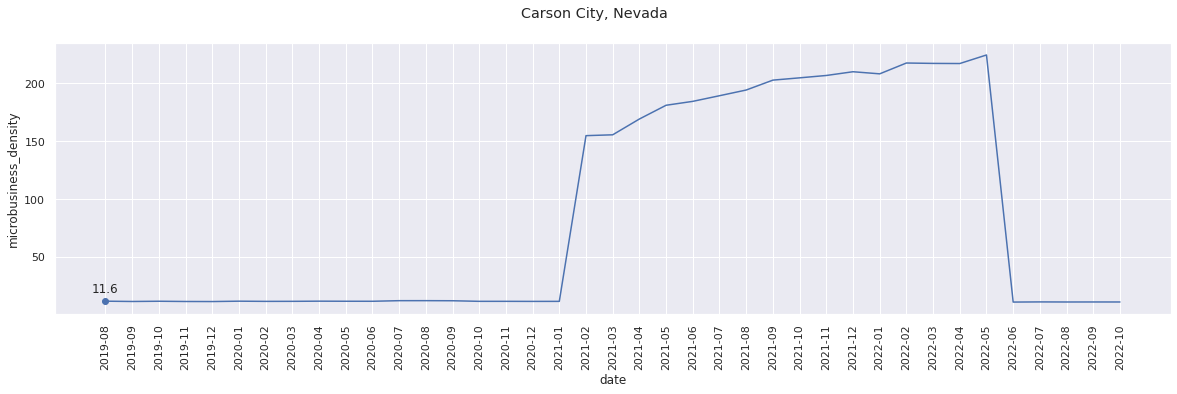

In [12]:
show_county(32510)

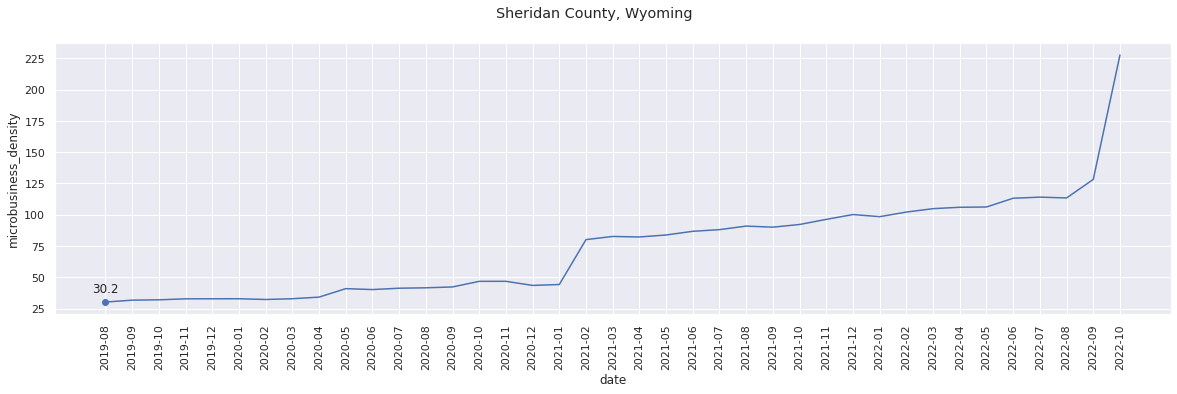

In [13]:
show_county(56033)

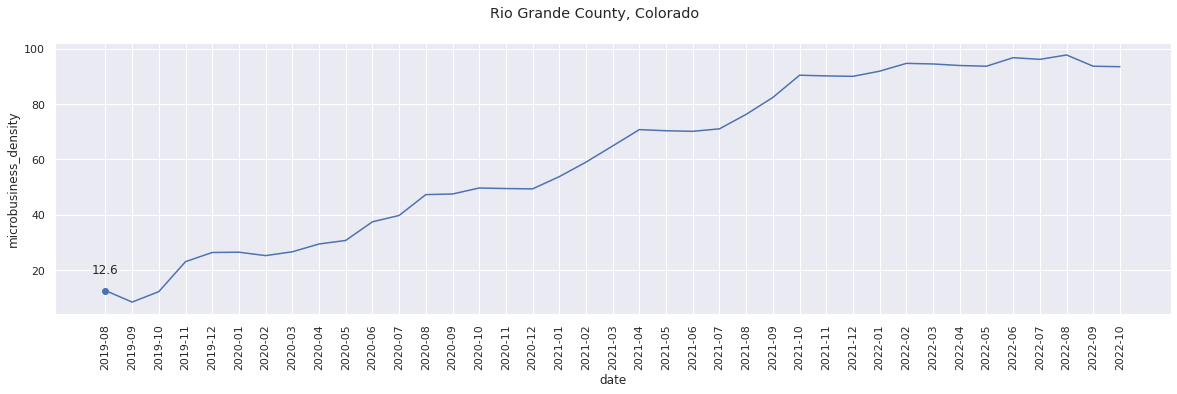

In [14]:
show_county(8105)

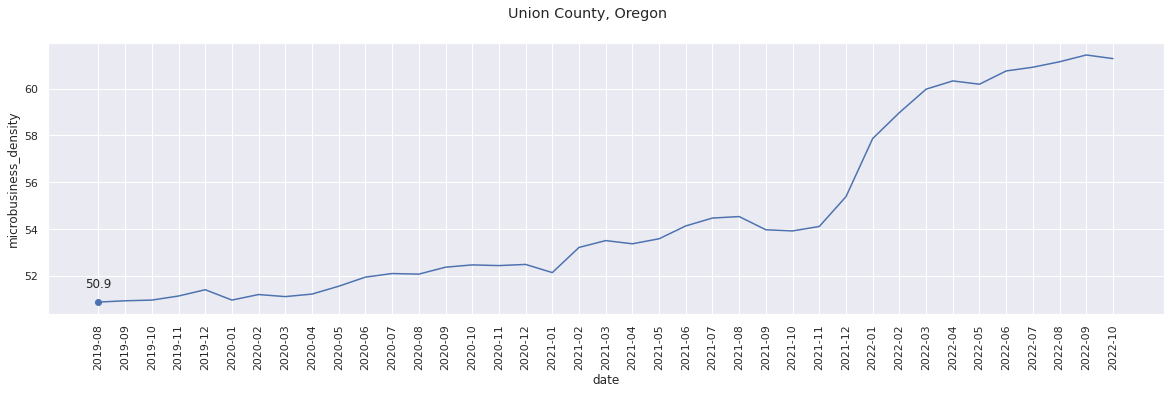

In [15]:
show_county(41061, txt_off=0.5)

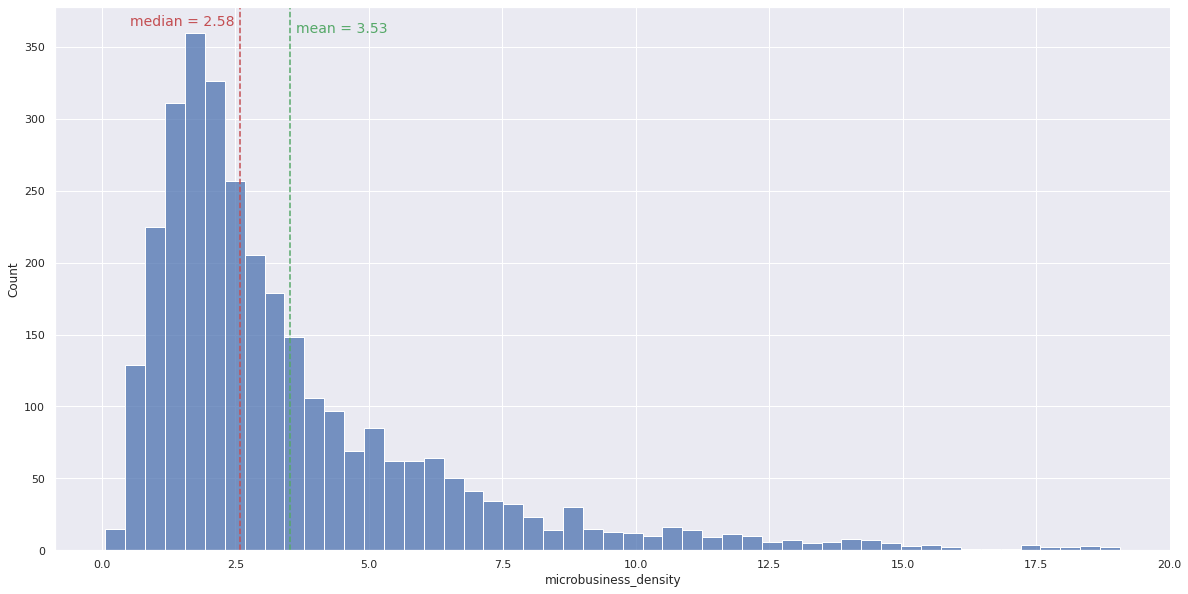

In [16]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
main_body = counties_mean[counties_mean['microbusiness_density']<q99]
sns.histplot(data=main_body, x='microbusiness_density', ax=ax)

mb_median = main_body['microbusiness_density'].median()
ax.axvline(mb_median, 0, c='r', ls='--')
ax.text(mb_median-0.1, 365, f"median = {mb_median:.2f}", size=14, horizontalalignment='right', c='r')

mb_mean = main_body['microbusiness_density'].mean()
ax.axvline(mb_mean, 0, c='g', ls='--')
ax.text(mb_mean+0.1, 360, f"mean = {mb_mean:.2f}", size=14, c='g')

plt.show()